In [1]:
#!/usr/bin/env python
# coding: utf-8

#!/usr/bin/env python
# coding: utf-8

import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys

from climada.util import coordinates as u_coords

    
import analysis.analysis_funcs as af
import analysis.plotting_funcs as pf
   
        


In [2]:

    # Variable definitions
    cntry = 'USA'
    state = 'Louisiana'
    haz_type = 'FL'
    iso3 = u_coords.country_to_iso(cntry)

    # paths
    PATH_ROOT = '/cluster/work/climate/evelynm/nw_outputs/'
    path_cntry_folder = PATH_ROOT+f'{iso3}/'
    path_state_folder = path_cntry_folder+f'{state}/'
    path_nodes = f'{path_state_folder}/cis_nw_nodes'
    path_save = path_state_folder    
    path_save_plots = path_state_folder+'plots/'
    path_event_stats = path_state_folder+f'service_stats_{haz_type}_{iso3}_{state}.pkl'
    path_base_stats = path_state_folder+f'base_stats_{iso3}_{state}.pkl'
 
    # new folders to be created
    if not os.path.exists(path_save_plots):
        os.makedirs(path_save_plots)
    if not os.path.exists(path_state_folder+'old/'):
        os.makedirs(path_state_folder+'old/')
    if not os.path.exists(path_state_folder+'small_events/'):
        os.makedirs(path_state_folder+'small_events/')

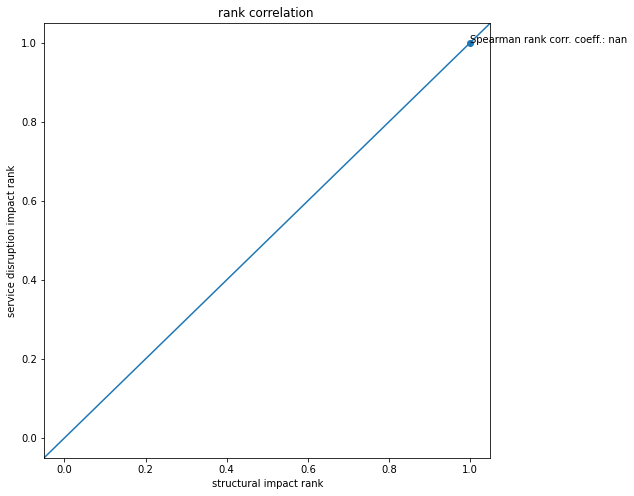

Cascade and access analysis was already performed. Aborting


TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [34]:
    #load files 
    gdf_nodes_orig = gpd.read_feather(path_nodes)
    base_stat_dict = af.load_dict(path_base_stats)
    base_stat_dict['people'] = 0
    event_stat_dict = af.load_dict(path_event_stats)
    
    # create summary dictionaries for basic service attainment
    access_rate_dict = af.access_rate_conversion(
        base_stat_dict, gdf_nodes_orig, abs_num=False)
    access_num_dict = af.access_rate_conversion(
        base_stat_dict, gdf_nodes_orig, abs_num=True)
    
    # pre-select for small events and move them for now
    disr_rate_dict = af.disruption_rate_conversion(
        event_stat_dict, access_num_dict)
    
    cutoff_popimp = 0.001 if haz_type=='TC' else 0.0001
    drop_events = af.select_insignificant_events(disr_rate_dict, cutoff_popimp)
    
    small_disr_rate_dict = {}
    small_event_stat_dict = {}
    for event_id in drop_events:
        small_disr_rate_dict[event_id] = disr_rate_dict[event_id]
        del disr_rate_dict[event_id]
        small_event_stat_dict[event_id] = event_stat_dict[event_id]
        del event_stat_dict[event_id]
    
    af.move_gdfs(path_state_folder, haz_type, 
                 valid_events=list(event_stat_dict.keys()),
                 small_events=list(small_event_stat_dict.keys()))
    
    dict_gdfs = af.load_gdf_dict(path_state_folder, haz_type, 
                                 valid_events=list(event_stat_dict.keys()))
    
    destruction_rate_dict = af.destruction_rate_conversion(dict_gdfs)
    af.save_dict(event_stat_dict, path_event_stats)
    af.save_dict(disr_rate_dict, path_state_folder+f'disruption_rates_{iso3}_{state}_{haz_type}.pkl')
    af.save_dict(destruction_rate_dict, path_state_folder+f'destruction_rates_{iso3}_{state}_{haz_type}.pkl')

    # correlation analysis
    spearmanr_res, ranklist = af.compare_impact_rankings(disr_rate_dict, destruction_rate_dict)
    pf.plot_rank_correlation(ranklist, spearmanr_res, 
                             list(event_stat_dict.keys()), 
                             haz_type=haz_type, save_path=path_save_plots)

    # aggregating event results
    for key, gdf in dict_gdfs.items():
        save_path = path_state_folder + f'cascade_results_{key}'
        dict_gdfs[key] = af.get_casc_and_access_states(gdf, gdf_nodes_orig, save_path=save_path)

    gdf_summed = sum_impacts(
        [gdf for gdf in dict_gdfs.values()], 
        save_path=path_state_folder+f'summed_impacts_{haz_type}_{iso3}_{state}')

    gdf_summed_popweighted = af.sum_impacts_popweighted(
        gdf_summed, 
        save_path=path_state_folder+f'summed_pop_impacts_{haz_type}_{iso3}_{state}')

    total_imps = af.get_total_imps(event_stat_dict)
    af.save_dict(total_imps, path_state_folder+f'total_service_disruptions_{iso3}_{state}_{haz_type}.pkl')

    # Factor C per event  & median (pop without service / pop with initial service access in dir. aff. region)
    perevent_factor_c = {}
    
    for event_id, imp_gdf in dict_gdfs.items():
        perevent_factor_c[event_id] = {}
        imp_gdf = imp_gdf[imp_gdf.ci_type=='people']
        for variable, service in af.service_dict().items():
            lost_service = imp_gdf[imp_gdf[variable]<0]['counts'].sum()
            # has or had service, in directly affected area
            had_service_affected = imp_gdf[(imp_gdf['imp_dir']>0) & (imp_gdf[variable]!=0)]['counts'].sum()
            perevent_factor_c[event_id][service] = np.round(np.abs(lost_service/had_service_affected),2)
            if lost_service==0:
                perevent_factor_c[event_id][service] = 0
        perevent_factor_c[event_id]['population'] = imp_gdf[(imp_gdf['imp_dir']>0)]['counts'].sum()/imp_gdf['counts'].sum()
    
    # convert to dataframe    
    df_factor_c = pd.DataFrame.from_dict(perevent_factor_c)
    df_factor_c['median'] = df_factor_c.apply(lambda row: np.nanmedian(row.values), axis=1)    
    df_factor_c.to_csv(path_state_folder+f'perevent_factor_c_{iso3}_{state}_{haz_type}.csv')


    # Factor B per event  & median (pop without service / pop without service in dir. aff. region)
    perevent_factor_b = {}
    
    for event_id, imp_gdf in dict_gdfs.items():
        perevent_factor_b[event_id] = {}
        imp_gdf = imp_gdf[imp_gdf.ci_type=='people']
        for variable, service in af.service_dict().items():
            # lost service anywhere
            lost_service = imp_gdf[imp_gdf[variable]<0]['counts'].sum()
            # lost service in directly affected area
            lost_service_affected = imp_gdf[(imp_gdf['imp_dir']>0) & (imp_gdf[variable]<0)]['counts'].sum()
            perevent_factor_b[event_id][service] = np.round(np.abs(lost_service/lost_service_affected),2)
            if lost_service==0:
                perevent_factor_c[event_id][service] = 0
        perevent_factor_b[event_id]['population'] = imp_gdf[(imp_gdf['imp_dir']>0)]['counts'].sum()/imp_gdf['counts'].sum()
    # convert to dataframe    
    df_factor_b = pd.DataFrame.from_dict(perevent_factor_b)
    df_factor_b['median'] = df_factor_b.apply(lambda row: np.nanmedian(row.values), axis=1)    
    df_factor_b.to_csv(path_state_folder+f'perevent_factor_b_{iso3}_{state}_{haz_type}.csv')
    
    
    # overview plots cumulative services (summary and spatially explicit)
    pf.casc_factor_boxplots(df_factor_c, df_factor_b, haz_type, save_path=path_save_plots)
    pf.service_cumimpact_plot(gdf_summed, haz_type=haz_type, save_path=path_save_plots)
    
    worst_events_s = [worst[1] for worst in 
                      af.get_worst_events(disr_rate_dict, n_min=int(3), 
                                          mode='service')]
    worst_events_f = [worst[1] for worst in 
                      af.get_worst_events(destruction_rate_dict, n_min=int(3), 
                                          mode='functionality')]

In [ ]:
gdf_summed = af.sum_impacts(
        [gdf for gdf in dict_gdfs.values()], 
        save_path=path_state_folder+f'summed_impacts_{haz_type}_{iso3}_{state}')


In [6]:
gdf_list = [gdf for gdf in dict_gdfs.values()]
services = [colname for colname in gdf_list[0].columns if 'actual_supply_' in colname]
gdf_services = gdf_list[0][gdf_list[0].ci_type=='people'][['counts', 'geometry']]

In [8]:
gdf_services

,counts,geometry
7252,97.636696,POINT (-92.73042 33.01208)
7253,353.496033,POINT (-92.72208 33.01208)
7254,205.291412,POINT (-92.71375 33.01208)
7255,20.537443,POINT (-92.66375 33.01208)
7256,22.505520,POINT (-94.01375 33.00375)
...,...,...
30158,29.334663,POINT (-90.00542 29.23708)
30159,146.409500,POINT (-89.99708 29.23708)
30160,22.541332,POINT (-90.01375 29.22875)
30161,58.852276,POINT (-90.02208 29.22042)


In [32]:
    services = [colname for colname in gdf_list[0].columns if 'actual_supply_' in colname]
    gdf_services = gdf_list[0][gdf_list[0].ci_type=='people'][['counts', 'geometry']]
    
    for service in services[2:]:
        service_counts = np.array(gdf_list[0][gdf_list[0].ci_type=='people'][service].values)
        for gdf in gdf_list[1:]:
            service_counts = np.vstack([service_counts, np.array(gdf[gdf.ci_type=='people'][service].values)])
        print(service, np.ma.masked_greater_equal(service_counts, 0).sum(axis=0))
        failures = np.ma.masked_greater_equal(service_counts, 0).sum(axis=0)
        if failures.dtype!= float:
            failures = failures.filled(np.nan)

actual_supply_health_people -8.0
actual_supply_power_line_people -11.0
actual_supply_road_people -1.0


In [27]:
failures = np.ma.masked_greater_equal(service_counts, 0).sum(axis=0)

In [31]:
len(failures)


TypeError: object of type 'numpy.float64' has no len()

In [12]:
np.ma.masked_greater_equal(service_counts, 0).filled(np.nan)

array([nan, nan, nan, ..., nan, nan, nan])

In [33]:
def sum_impacts(gdf_list, save_path=None):
    # sum up amounts of service failure events across all result gdfs
    services = [colname for colname in gdf_list[0].columns if 'actual_supply_' in colname]
    gdf_services = gdf_list[0][gdf_list[0].ci_type=='people'][['counts', 'geometry']]
    
    for service in services:
        service_counts = np.array(gdf_list[0][gdf_list[0].ci_type=='people'][service].values)
        for gdf in gdf_list[1:]:
            service_counts = np.vstack([service_counts, np.array(gdf[gdf.ci_type=='people'][service].values)])
        failures = np.ma.masked_greater_equal(service_counts, 0).sum(axis=0)
        if failures.dtype!= float:
            failures = failures.filled(np.nan)
        inavails = np.ma.masked_not_equal(service_counts, 0).sum(axis=0)
        if inavails.dtype!= float:
            inavails = inavails.filled(np.nan)
        failures[~np.isnan(inavails)] = 0.
        failures[np.isnan(failures)] = 1.
        gdf_services[service] = failures
    
    impact_counts = np.round(np.array(gdf_list[0][gdf_list[0].ci_type=='people']['imp_dir'].values/
                             gdf_list[0][gdf_list[0].ci_type=='people']['counts'].values), 0)
    for gdf in gdf_list[1:]:
        impact_counts += np.round(np.array(gdf[gdf.ci_type=='people']['imp_dir'].values/gdf[gdf.ci_type=='people']['counts'].values), 0)
    gdf_services['imp_dir'] = impact_counts*-1 
    
    if save_path is not None:
        gdf_services.to_feather(save_path)
        
    return gdf_services

In [5]:
event_stat_dict

{'DFO_4388': {'power': 12357.315813064575,
  'healthcare': 398.7794780731201,
  'education': 7787.849853515625,
  'telecom': 0.0,
  'mobility': 53.50503921508789,
  'people': 1853.9400749206543}}

In [ ]:
    if haz_type=='TC':
        pf.plot_worst_tc_tracks(worst_events_s,
                                save_path=path_save_plots)
    elif haz_type=='FL':
        pass
        #pf.plot_worst_floods(worst_events_s, path_cntry_folder, iso3, 
        #                     save_path=path_save_plots)

In [8]:
    div_events = af.get_diverging_events(event_stat_dict, ranklist)
    
    pf.plot_total_impacts_bars(total_imps, haz_type, f'{state} ({cntry})', save_path=path_save_plots)
    


In [20]:

        
    
    # =============================================================================
    # Create a summary-pdf document with most important outputs
    # =============================================================================
    
    # heavily uses pylatex package 
    
    from pylatex import Document, Section, Subsection, Tabular, Figure, MiniPage,LargeText, LineBreak
    from pylatex.utils import bold
    import os
    
    # define necessary save and lookup paths
    
    path_root = 'countries/' 
    #change this according to where it is called from - now expects .tex file & .png files in same folder countries/iso3/ 
    path_imp_cum_plot = path_root+f'service_disruptions_cum_{haz_type}.png'
    path_imp_tot_plot = path_root+f'tot_serv_impacts_bars_{haz_type}.png'
    path_rankstats = path_root+f'event_rankings_{haz_type}.png'
    path_cascfactor_bplots = path_root+f'cascfactor_boxplots_{haz_type}.png'
    worst_event_header_s = ['Event Name']
    worst_event_header_s.extend(list(base_stat_dict.keys()))
    worst_event_header_f = ['Event Name']
    worst_event_header_f.extend(list(list(destruction_rate_dict.values())[0].keys()))
    path_worst_event_plot = path_root+f'worst_events_{haz_type}.png'
    
    year_range = '1980-2020' 
    if haz_type=='FL':
        year_range = '2002-2018'
    elif haz_type=='RF':
        year_range = '1971-2005'
    
    geometry_options = {"tmargin": "2cm", "lmargin": "2cm", "rmargin": "2cm"}
    doc = Document(geometry_options=geometry_options)
    
    # Add Heading
    with doc.create(MiniPage(align='c')):
        doc.append(LargeText(bold(f"Summary Output for {haz_type}s, {state} ({cntry}), {year_range}")))
        doc.append(LineBreak())
            
    with doc.create(Section('Base case: Access rates statistics')):
        with doc.create(Tabular('lllll')) as table:
            table.add_hline()
            table.add_row(list(base_stat_dict.keys())[:-1])
            table.add_hline()
            table.add_empty_row()
            table.add_row(np.round(np.array(list(access_rate_dict.values())[:-1])*100,1))
        doc.append(LineBreak())
        doc.append('Access rates to respective services (%)')

    with doc.create(Section('Cascade factors of service disruptions')):
        with doc.create(Figure(position='h!')) as imp_pic:
            imp_pic.add_image(path_cascfactor_bplots, width='350px')
            imp_pic.add_caption(f'Cascade factor metrics for servcice disruptions from {haz_type} {year_range}, {state} ({cntry})')

    with doc.create(Section('Cumulative service disruption impacts')): 
        doc.append(f'Number of {haz_type} events: {len(disr_rate_dict)}')
        
        with doc.create(Figure(position='h!')) as imp_pic:
            imp_pic.add_image(path_imp_tot_plot, width='250px')
            imp_pic.add_caption(f'People impacted by service disruptions from {haz_type} {year_range}, {state} ({cntry})')
            
        with doc.create(Figure(position='h!')) as imp_pic:
            imp_pic.add_image(path_imp_cum_plot, width='550px')
            imp_pic.add_caption(f'Spatial maps of service disruptions from {haz_type} {year_range}, {state} ({cntry})')
            
    with doc.create(Tabular('llllll')) as table:
            table.add_empty_row()
            table.add_empty_row()
            table.add_empty_row()
            table.add_empty_row()
        
    
    with doc.create(Section('Worst events overview')):
        with doc.create(Subsection('Worst event stats: Service Disruptions')):
            with doc.create(Tabular('lllllll')) as table:
                    table.add_hline()
                    table.add_row(worst_event_header_s)
                    table.add_hline()
                    table.add_empty_row()
                    for worst_event in worst_events_s:
                        table.add_row(list(np.append((worst_event), 
                                                     np.round(np.array(list(disr_rate_dict[worst_event].values()))*100,
                                                              1))))
                    table.add_empty_row()

            doc.append(LineBreak())
            doc.append('Worst events with respect to service access disruptions (%, relative to base state)')
        
        with doc.create(Subsection('Worst event stats: Direct Damages')):
            with doc.create(Tabular('lrrrrrr')) as table:
                    table.add_hline()
                    table.add_row(worst_event_header_f)
                    table.add_hline()
                    table.add_empty_row()
                    for worst_event in worst_events_f:
                        table.add_row(list(np.append((worst_event), 
                                                     np.round(np.array(list(destruction_rate_dict[worst_event].values())),
                                                              3))))
                    table.add_empty_row()
                    
            doc.append(LineBreak())
            doc.append('Worst events with respect to direct (structural) damages. In % relative to total units.')
            
            if haz_type != 'FL':
                with doc.create(Figure(position='h!')) as imp_pic:
                    imp_pic.add_image(path_worst_event_plot, width='350px')
                    imp_pic.add_caption(f'Worst {haz_type} events, {state} ({cntry})')


            with doc.create(Subsection('Event ranks comparison')):
                with doc.create(Figure(position='htbp')) as imp_pic:
                    imp_pic.add_image(path_rankstats, width='350px')
                    imp_pic.add_caption('Comparison of event severeness ranks between direct impact metrics and service disruption metrics')
                doc.append('Most diverging events in ranking (> 20% rank difference):')
                doc.append(LineBreak())
                for event in list(div_events):
                    doc.append(event)
                    doc.append(LineBreak())
                

    doc.generate_tex(filepath=path_state_folder+f'summary_pages_{haz_type}_{iso3}_{state}')

